# Analyse sytaktischer N-Grams

## Hinweise zur Ausführung des Notebooks
Dieses **Notebook** kann auf unterschiedlichen Levels erarbeitet werden (siehe Abschnitt ["Technische Voraussetzungen"](../introduction/introduction_requirements)): 
1. Book-Only Mode
2. Cloud Mode: Dafür auf 🚀 klicken und z.B. in Colab ausführen.
3. Local Mode: Dafür auf Herunterladen ↓ klicken und ".ipynb" wählen. 

## Übersicht 
Im Folgenden werden die annotierten Dateien (CSV-Format) analysiert. 

<details>
  <summary><b>Informationen zum Ausführen des Notebooks – Zum Ausklappen klicken ⬇️</b></summary>
  
<b>Voraussetzungen zur Ausführung des Jupyter Notebooks</b>
<ol>
<li> Installieren der Bibliotheken </li>
<li> Pfad zu den Daten setzen</li>
<li> Laden der Daten (z.B. über den Command `wget` (s.u.))</li>
</ol>
Zum Testen: Ausführen der Zelle "load libraries" und der Sektion "Einlesen der Daten". </br>
Alle Zellen, die mit 🚀 gekennzeichnet sind, werden nur bei der Ausführung des Noteboos in Colab / JupyterHub bzw. lokal ausgeführt. 
</details>

In [1]:
from pathlib import Path
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
metadata = pd.read_csv("../metadata/metadata_corpus-german_language_fiction.csv")

In [7]:
metadata_timeframe = metadata[(metadata.year > 1800) & (metadata.year < 1920)]

<Axes: xlabel='year'>

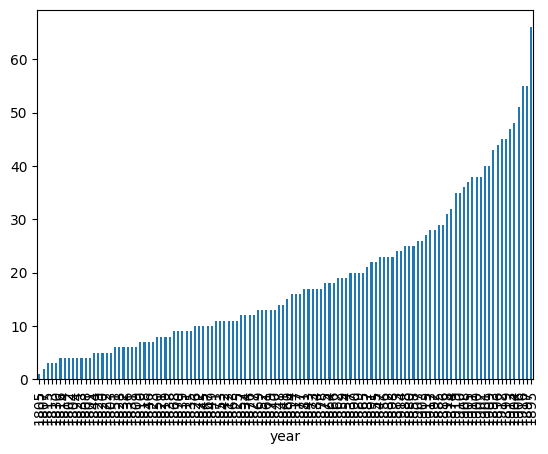

In [10]:
metadata_timeframe.year.value_counts(ascending=True).plot(kind="bar")

In [2]:
corpus_annotated_dir = Path(r"../data/csv")

corpus= {}
for fp in corpus_annotated_dir.iterdir():
    if fp.is_file():
        df = pd.read_csv(fp)
        corpus[fp.stem] = df

In [85]:
# Find adjectives followed by noun "Luft"
mask = (df['POS'] == 'ADJ') & \
       (df['POS'].shift(-1) == 'NOUN') & \
       (df['Lemma'].shift(-1) == 'Luft')

In [86]:
threshold = 5
# either filter here or later when plotting
adj_counts = {}
for fn, df in corpus.items():
    if fn in metadata_timeframe.ID.values:
        mask = (df['POS'] == 'ADJ') & \
       (df['POS'].shift(-1) == 'NOUN') & \
       (df['Lemma'].shift(-1) == 'Luft')
        
        adjective_lemmata_counts = df[mask].Lemma.value_counts()
        #adjective_lemmata_counts = adjective_lemmata_counts[adjective_lemmata_counts >= threshold]
        adjective_lemmata_counts = adjective_lemmata_counts / len(df)
        adj_counts[fn] = adjective_lemmata_counts.to_dict()
adj_df = pd.DataFrame.from_dict(adj_counts, orient='index')
result_df = metadata_timeframe.merge(adj_df, left_on='ID', right_index=True, how='left')    

In [87]:
result_df = result_df.fillna(0)

In [82]:
result_df.head()

,lastname,firstname,title,year,volume,ID,geweiht,still,frisch,mild,...,Schwül,gletscherkühl,flimmernde,frisch-kühl,orntlich,stahlkräftig,Stuttgarter,lehrhaft,Hamburger,beschmutzt
0,Walloth,Wilhelm,Das Schatzhaus des Königs,1883,0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Eyth,Max,Der Schneider von Ulm,1906,0,0.0,0.0,0.000000,0.000007,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Spielhagen,Friedrich,Platt Land,1878,0,0.0,0.0,0.000005,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Stifter,Adalbert,Ein Gang durch die Katakomben,1844,0,0.0,0.0,0.000000,0.000157,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Stern,Adolf,Vor Leyden,1866,0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
meta_columns = ["lastname", "firstname", "title", "year", "volume", "ID"]
adjective_columns = [col for col in result_df.columns if col not in meta_columns]

In [89]:
# cast to int, set invalid values to NaN
result_df[adjective_columns] = result_df[adjective_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

In [90]:
yearly_adj = result_df.groupby('year')[adjective_columns].mean()


In [74]:
top_adjs = yearly_adj.sum().sort_values(ascending=False).head(5).index
yearly_top = yearly_adj[top_adjs]

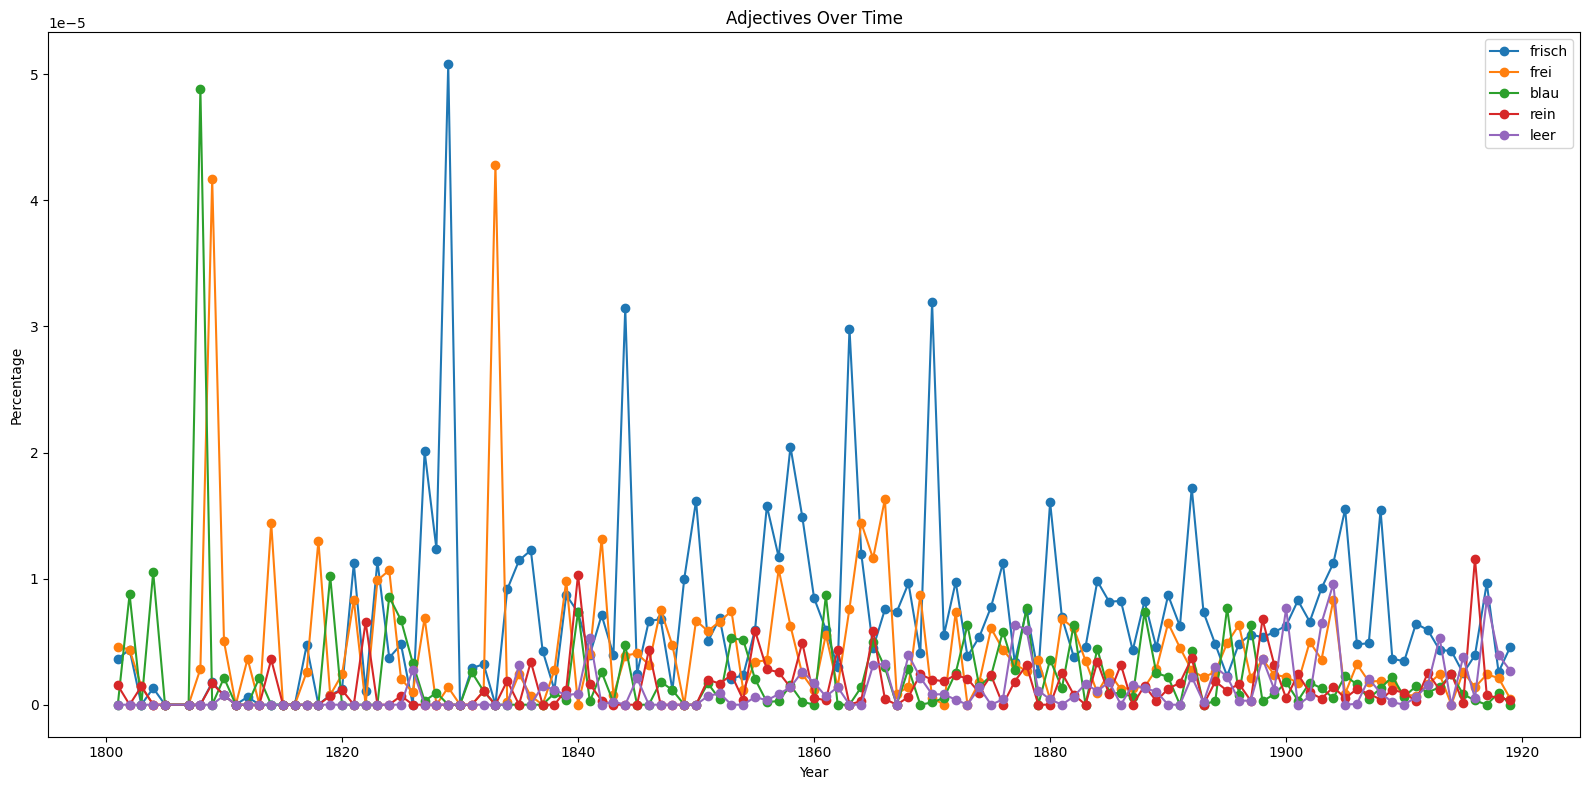

In [80]:
yearly_top.plot(marker='o', figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title(f'Adjectives Over Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

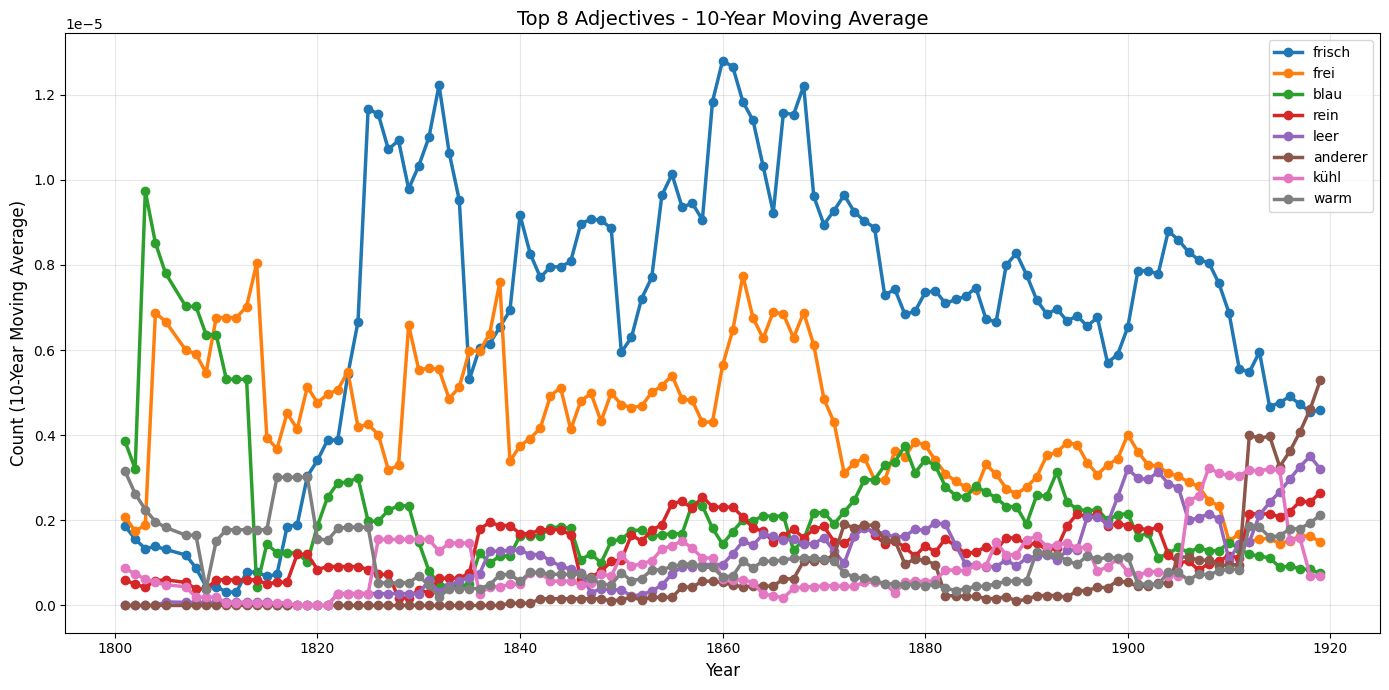

In [100]:
# Fix dtype if needed
metadata_cols = ["lastname", "firstname", "title", "year", "volume", "ID"]
adj_columns = [col for col in result_df.columns if col not in metadata_cols]
result_df[adj_columns] = result_df[adj_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

# Get the overall top adjectives
total_counts = result_df[adj_columns].sum().sort_values(ascending=False)
top_n = 10
top_adjectives = total_counts.head(top_n).index.tolist()

# Sort by year first
result_df_sorted = result_df.sort_values('year').copy()

# Method 1: 10-year window on yearly aggregates
yearly_data = result_df.groupby('year')[top_adjectives].mean()
window_years = 10
moving_avg_10yr = yearly_data.rolling(window=window_years, center=True, min_periods=1).mean()

# Plot 10-year moving average
plt.figure(figsize=(14, 7))

for adj in top_adjectives[:8]:  # Plot top 8 for clarity
    # Plot original data as faint dots
    #plt.plot(yearly_data.index, yearly_data[adj], 
             #'o', alpha=0.2, markersize=4, color='gray')
    
    # Plot 10-year moving average as solid lines
    plt.plot(moving_avg_10yr.index, moving_avg_10yr[adj], 
             linewidth=2.5, label=adj, marker='o', markersize=6)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Count (10-Year Moving Average)', fontsize=12)
plt.title(f'Top {min(8, top_n)} Adjectives - 10-Year Moving Average', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
from scipy import stats

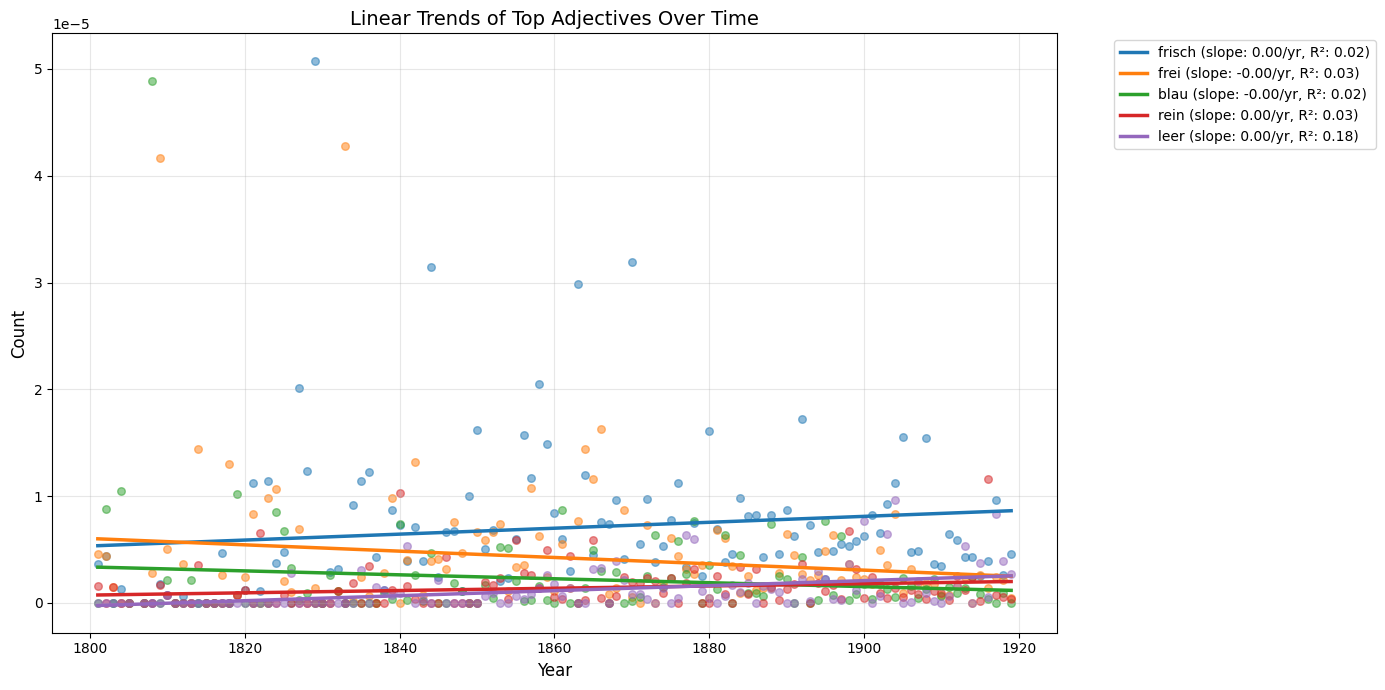

In [106]:
fig, ax = plt.subplots(figsize=(14, 7))

for adj in top_adjectives[:5]:
    # Original data points
    x = yearly_data.index.values
    y = yearly_data[adj].values
    
    # Calculate linear trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    trend_line = slope * x + intercept
    
    # Plot original data as scatter
    ax.scatter(x, y, alpha=0.5, s=30)
    
    # Plot trend line
    ax.plot(x, trend_line, linewidth=2.5, 
            label=f'{adj} (slope: {slope:.2f}/yr, R²: {r_value**2:.2f})')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Linear Trends of Top Adjectives Over Time', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [109]:
import numpy as np

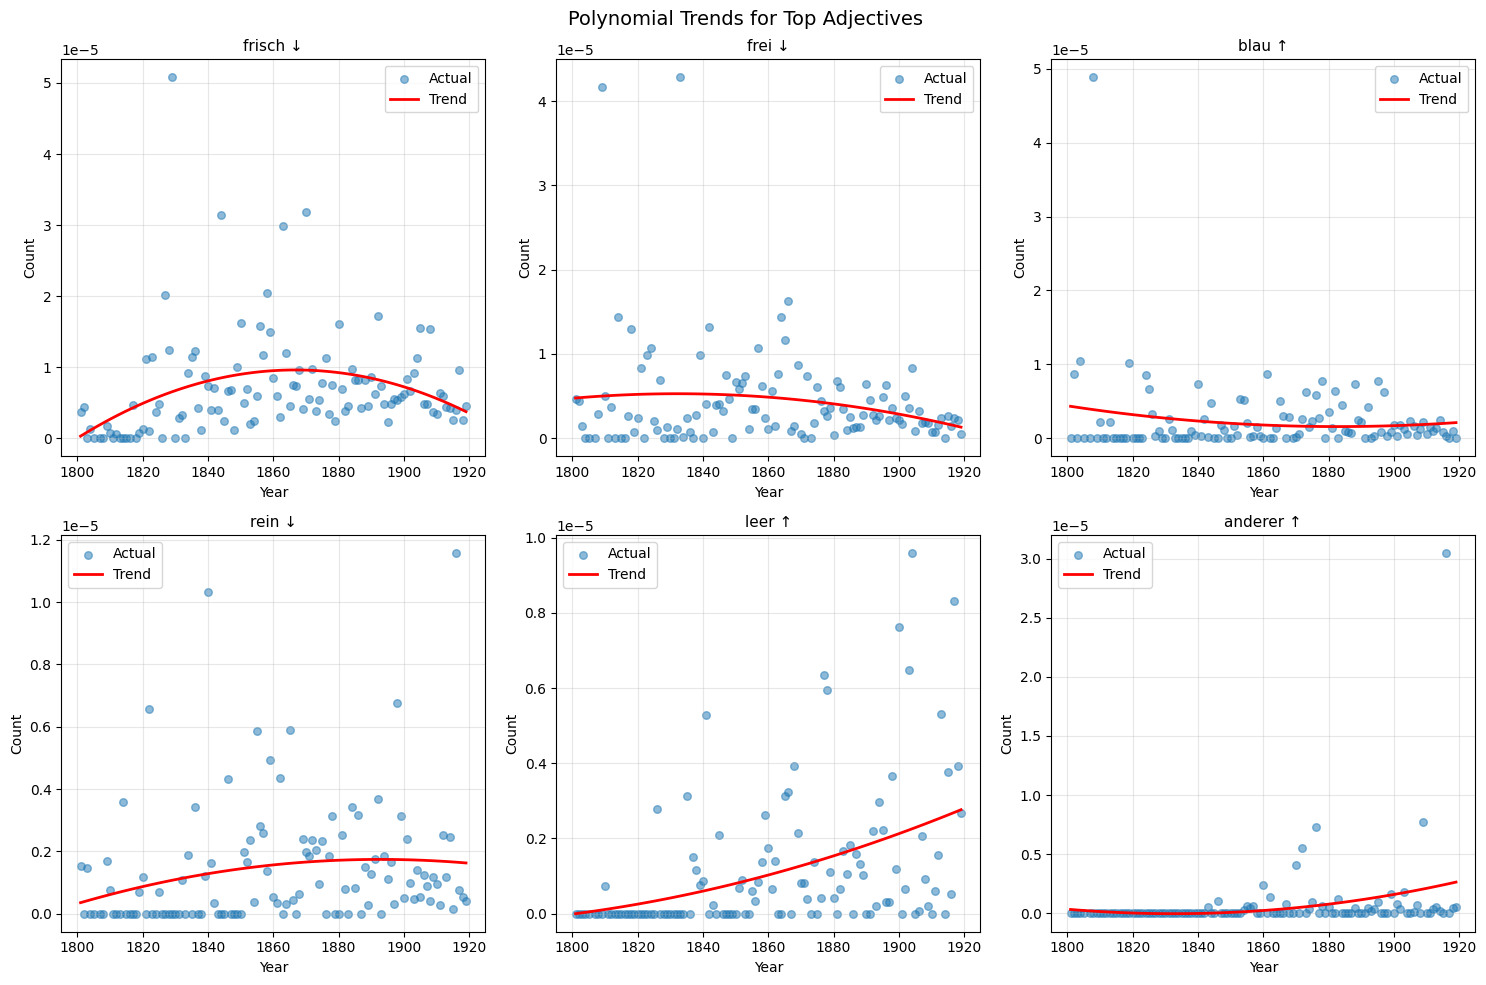

In [110]:
# Polynomial trends can capture curves and turning points
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, adj in enumerate(top_adjectives[:6]):
    ax = axes[idx]
    
    x = yearly_data.index.values
    y = yearly_data[adj].values
    
    # Fit polynomial of degree 2 (quadratic)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    
    # Generate smooth curve
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_smooth = p(x_smooth)
    
    # Plot
    ax.scatter(x, y, alpha=0.5, s=30, label='Actual')
    ax.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Trend')
    
    # Add trend direction indicator
    trend_direction = "↑" if p.deriv()(x[-1]) > 0 else "↓"
    ax.set_title(f'{adj} {trend_direction}', fontsize=11)
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle('Polynomial Trends for Top Adjectives', fontsize=14)
plt.tight_layout()
plt.show()

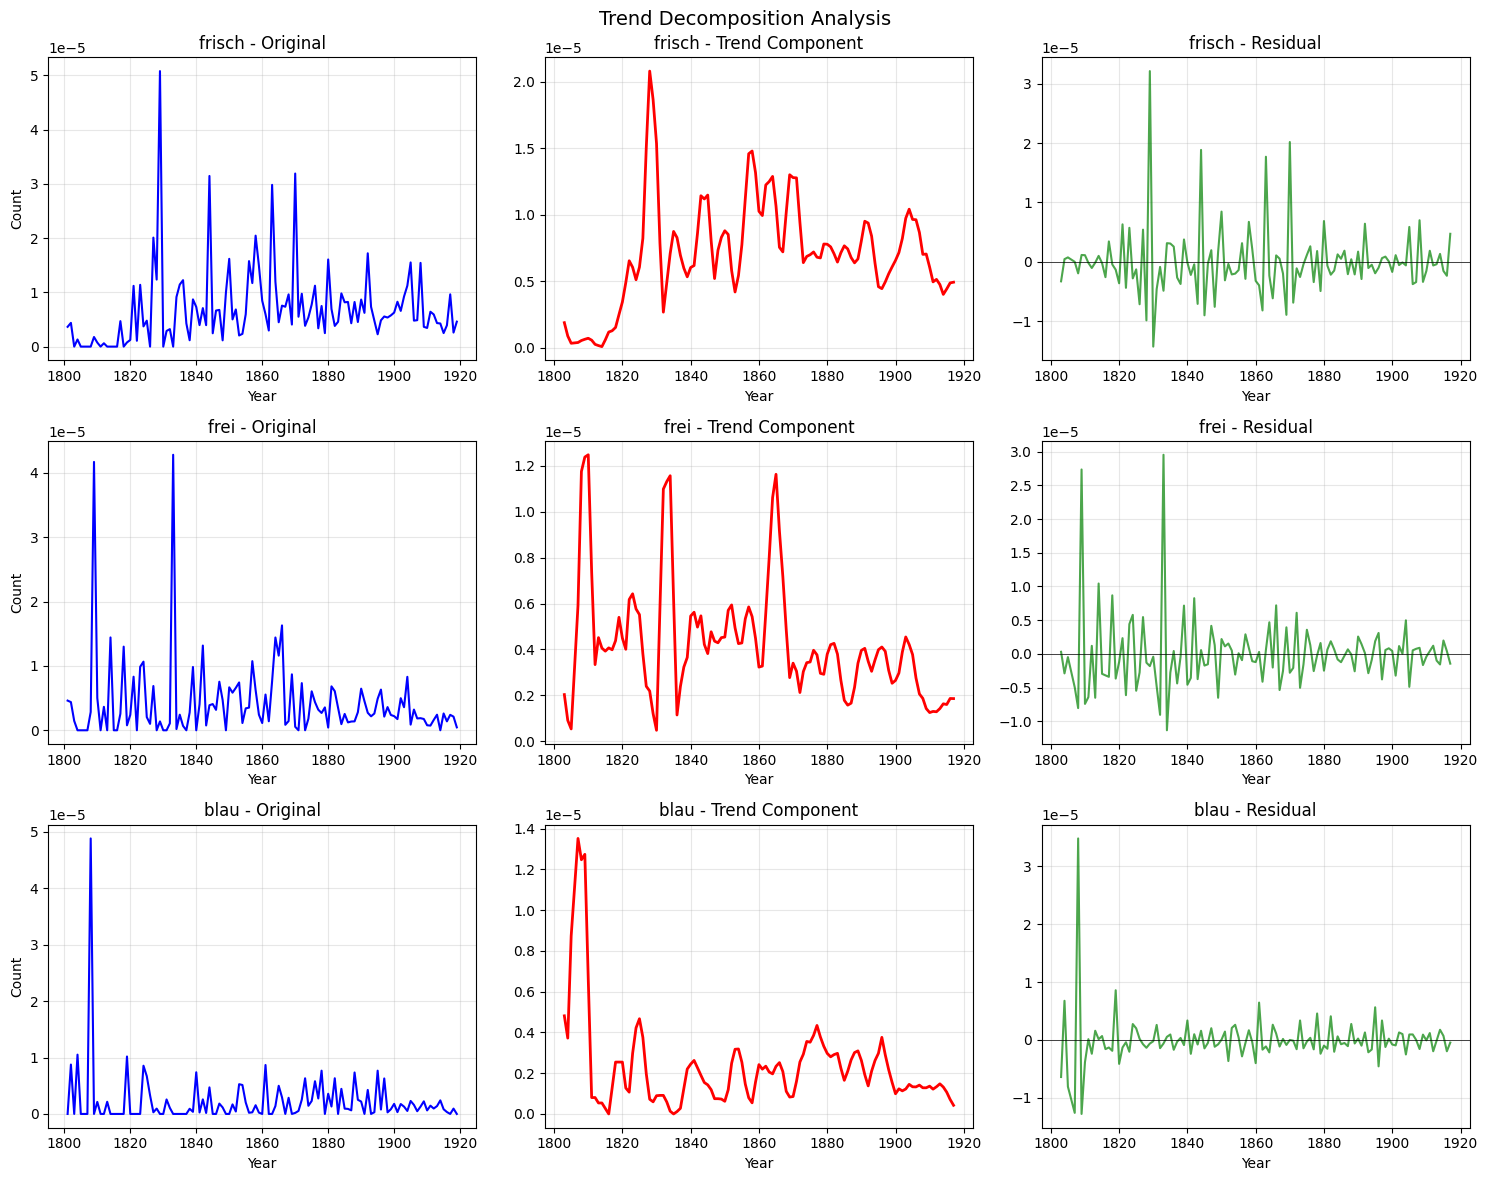

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

# For each adjective, decompose into trend, seasonal, residual
fig, axes = plt.subplots(len(top_adjectives[:3]), 3, figsize=(15, 12))

for idx, adj in enumerate(top_adjectives[:3]):
    # Get the time series for this adjective
    ts = yearly_data[adj]
    
    # Perform decomposition (if you have enough data points)
    if len(ts) > 4:
        decomposition = seasonal_decompose(ts, model='additive', period=min(4, len(ts)//2))
        
        # Plot original
        axes[idx, 0].plot(ts.index, ts.values, 'b-', linewidth=1.5)
        axes[idx, 0].set_title(f'{adj} - Original')
        axes[idx, 0].set_ylabel('Count')
        
        # Plot trend
        axes[idx, 1].plot(decomposition.trend.index, decomposition.trend.values, 'r-', linewidth=2)
        axes[idx, 1].set_title(f'{adj} - Trend Component')
        
        # Plot residual
        axes[idx, 2].plot(decomposition.resid.index, decomposition.resid.values, 'g-', alpha=0.7)
        axes[idx, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx, 2].set_title(f'{adj} - Residual')

for ax in axes.flat:
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Year')

plt.suptitle('Trend Decomposition Analysis', fontsize=14)
plt.tight_layout()
plt.show()

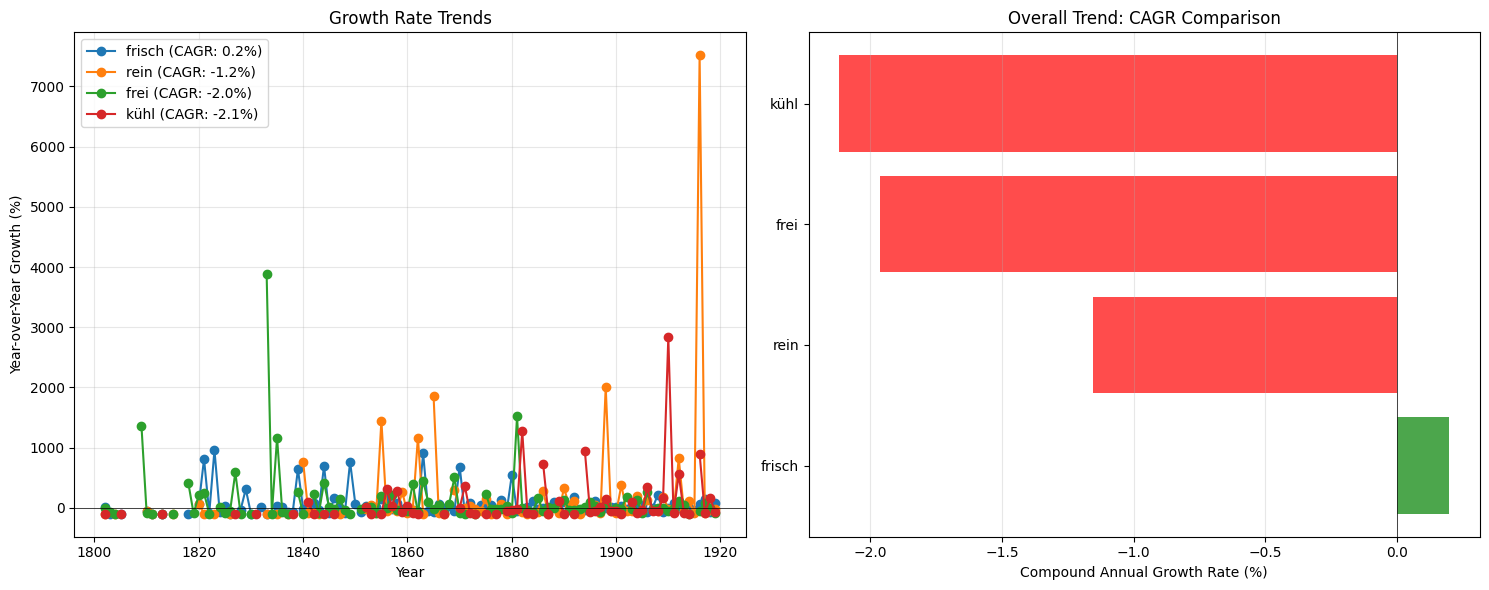

In [114]:
# Calculate and visualize growth rates
yearly_data = result_df.groupby('year')[top_adjectives].mean()

# Calculate year-over-year growth rate
growth_rates = yearly_data.pct_change() * 100

# Calculate compound annual growth rate (CAGR)
n_years = len(yearly_data) - 1
cagr = {}
for adj in top_adjectives:
    start_val = yearly_data[adj].iloc[0]
    end_val = yearly_data[adj].iloc[-1]
    if start_val > 0:
        cagr[adj] = (((end_val / start_val) ** (1/n_years)) - 1) * 100

# Sort by CAGR
cagr_sorted = dict(sorted(cagr.items(), key=lambda x: x[1], reverse=True))

# Visualize growth trends
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Growth rates over time
for adj in list(cagr_sorted.keys())[:5]:
    ax1.plot(growth_rates.index[1:], growth_rates[adj].iloc[1:], 
             marker='o', label=f'{adj} (CAGR: {cagr[adj]:.1f}%)')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Year-over-Year Growth (%)')
ax1.set_title('Growth Rate Trends')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: CAGR comparison
adj_names = list(cagr_sorted.keys())[:10]
cagr_values = [cagr_sorted[adj] for adj in adj_names]
colors = ['green' if v > 0 else 'red' for v in cagr_values]

ax2.barh(range(len(adj_names)), cagr_values, color=colors, alpha=0.7)
ax2.set_yticks(range(len(adj_names)))
ax2.set_yticklabels(adj_names)
ax2.set_xlabel('Compound Annual Growth Rate (%)')
ax2.set_title('Overall Trend: CAGR Comparison')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()